<h1>Real-Time Video Captioning</h1>

<h3>Importing Libraries and Dependecies</h3>

In [1]:
import os
import time
import sys
import string
import pickle

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.applications.xception import Xception

from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add, Concatenate, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import pad_sequences

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tqdm.notebook import tqdm

<h3>Data Extraction</h3>

In [2]:
df = pd.read_csv("captions.txt", nrows=2500)

In [47]:
df.head(6)

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting


<h3>Data Exploratory Analysis</h3>

In [158]:
df.shape

(40455, 2)

In [5]:
df.columns

Index(['image', 'caption'], dtype='object')

In [6]:
df.dtypes

image      object
caption    object
dtype: object

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40455 entries, 0 to 40454
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   image    40455 non-null  object
 1   caption  40455 non-null  object
dtypes: object(2)
memory usage: 632.2+ KB


In [14]:
df.describe()

,image,caption
count,10000,10000
unique,2000,9977
top,1000268201_693b08cb0e.jpg,Two dogs play in the grass .
freq,5,3


<h3>Data Preprocessing Steps</h3>

<h4>1. Validation and Cleansing</h4>

In [9]:
df.isna().sum()

image      0
caption    0
dtype: int64

In [3]:
df.duplicated().sum()

0

In [4]:
df.drop_duplicates(inplace=True)

In [10]:
df.duplicated().sum()

0

In [15]:
# Function to load GloVe embeddings into a dictionary
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Provide the path to your downloaded GloVe file
glove_file_path = '../dataset/embed/glove.6B.100d.txt'  # Change the path and dimensionality accordingly

# Load GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_file_path)

In [16]:
# Create an embedding matrix for your vocabulary
embedding_dim = 100  # Change the dimensionality based on your GloVe model

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Model Development

In [5]:
img_model = VGG16()
img_model = Model(inputs=img_model.inputs, outputs=img_model.layers[-2].output)

In [6]:
img_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [21]:
img_model.output.shape[1]

4096

In [171]:
# extract features from image
img_features = {}
directory = "../dataset/images"

for name_img in tqdm(df['image']):
    path_img = directory + '/' + name_img
    img = load_img(path_img, target_size=(224, 224))
    img = img_to_array(img)
    img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)
    feat = img_model.predict(img, verbose=0)
    id_img = name_img.split('.')[0]
    img_features[id_img] = feat

  0%|          | 0/2500 [00:00<?, ?it/s]

In [172]:
with open("../dataset/features.pkl", 'wb') as file:
    pickle.dump(img_features, file)
    file.close()

In [7]:
with open("../dataset/features.pkl", 'rb') as file:
    img_features = pickle.load(file)
    file.close()

In [8]:
def create_mappings(df):
    mappings = {}
    
    for idx, img in enumerate(df['image']):
        img_name = img.split('.')[0]
        mappings[img_name] = mappings.get(img_name, []) + [df.iloc[idx]['caption']] 
    return mappings

In [9]:
mappings = create_mappings(df)

In [10]:
def clean_captions(mappings):
    for cap_key, cap_list in mappings.items():
        for i in range(len(cap_list)):
            text = cap_list[i]
            text = text.lower()
            text = text.replace('[^A-Za-z]', '')
            text = text.replace('\s+', ' ')
            text = 'startseq ' + " ".join([word for word in text.split() if len(word)>1]) + ' endseq'
            cap_list[i] = text

In [11]:
clean_captions(mappings)

In [12]:
all_captions = []
for idx in mappings:
    for cap in mappings[idx]:
        all_captions.append(cap)

In [13]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [15]:
with open("./videocaptioninGUI/tokenizer.pkl", "wb") as file

In [14]:
vocab_size

2174

In [16]:
# get maximum length of the caption available
max_length = max([len(cap_text.split()) for cap_text in all_captions])
max_length

29

In [17]:
# Function to load GloVe embeddings into a dictionary
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Provide the path to your downloaded GloVe file
glove_file_path = '../dataset/embed/glove.6B.100d.txt'  # Change the path and dimensionality accordingly

# Load GloVe embeddings
glove_embeddings = load_glove_embeddings(glove_file_path)

In [18]:
# Create an embedding matrix for your vocabulary
embedding_dim = 100  # Change the dimensionality based on your GloVe model

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [183]:
embedding_matrix.shape

(6154, 100)

In [30]:
def gen_data(img_ids, mappings, img_features, tokenizer, maxlen, vocab_size, batch_size):
    while True:
        IN1, IN2, OUT = [], [], []
        
        for id_img in img_ids:
            cap_list = mappings[id_img]
            
            for caption in cap_list:
                seq = tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=maxlen)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    IN1.append(img_features[id_img][0])
                    IN2.append(in_seq)
                    OUT.append(out_seq)
                    
                    if len(IN1) == batch_size:
                        yield [np.array(IN1), np.array(IN2)], np.array(OUT)
                        IN1, IN2, OUT = [], [], []


In [14]:
image_ids = list(mappings.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [20]:
image_input = Input(shape=img_model.layers[-2].output.shape[1],)
dropout_image = Dropout(rate=0.45) (image_input)
dense_image = Dense(256, activation="relu")(dropout_image)

caption_input = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length,
                           weights=[embedding_matrix], trainable=False)(caption_input)
dropout_caption = Dropout(rate=0.45) (embedding_layer)
lstm = LSTM(256, return_sequences=False)(dropout_caption)


merged_layer = add([dense_image, lstm])
decoder = Dense(256, activation='relu')(merged_layer)
output = Dense(vocab_size, activation='softmax')(decoder)

# Create the caption generation model
caption_model = Model(inputs=[image_input, caption_input], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 29)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 29, 100)              217400    ['input_4[0][0]']             
                                                                                                  
 dropout_1 (Dropout)         (None, 4096)                 0         ['input_3[0][0]']             
                                                                                            

In [58]:
# train the model
epochs = 50
batch_size = 256
steps = len(train) // batch_size

for i in range(epochs):
    # create data generator
    generator = gen_data(train, mappings, img_features, tokenizer, max_length, vocab_size, batch_size)
    # fit for one epoch
    caption_model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

1/1 [==============================] - 0s 376ms/step - loss: 0.6788 - accuracy: 0.8242


In [59]:
with open("./videocaptioningUI/caption_model.pkl", "wb") as file:
    pickle.dump(caption_model, file)
    file.close()

In [33]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [34]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [41]:
from PIL import Image

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = f"../dataset/images/{image_name}"
    image = Image.open(img_path)
    captions = mappings[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(caption_model, img_features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

In [37]:
print(df['image'])

0       1000268201_693b08cb0e.jpg
1       1000268201_693b08cb0e.jpg
2       1000268201_693b08cb0e.jpg
3       1000268201_693b08cb0e.jpg
4       1000268201_693b08cb0e.jpg
                  ...            
2495    1463732807_0cdf4f22c7.jpg
2496    1463732807_0cdf4f22c7.jpg
2497    1463732807_0cdf4f22c7.jpg
2498    1463732807_0cdf4f22c7.jpg
2499    1463732807_0cdf4f22c7.jpg
Name: image, Length: 2500, dtype: object


---------------------Actual---------------------
startseq boy on playground swing strikes medatative pose endseq
startseq boy on swing wearing green shirt is making hand gestures endseq
startseq young boy makes meditational pose on swing endseq
startseq boy in green shirt sitting in swing with eyes closed and making gesture with hands endseq
startseq boy posing for camera endseq
--------------------Predicted--------------------
startseq man on bench with endseq


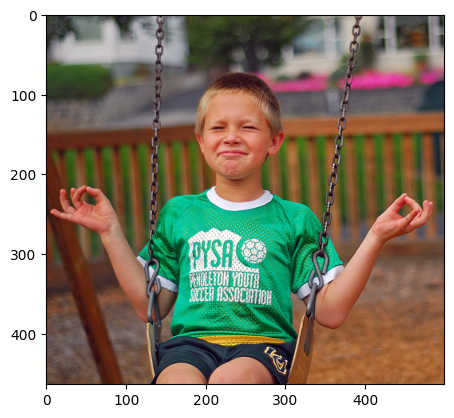

In [46]:
generate_caption("1463732807_0cdf4f22c7.jpg")

In [49]:
image_path = '../dataset/sample_img/sample3.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = img_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(caption_model, feature, tokenizer, max_length)

'startseq little with with with with endseq'